In [1]:
from __future__ import division
from aqchem.chemistry import Solute
from aqchem.equilibria import Equilibrium, EqSystem, charge_balance, atom_balance, REqSystem
import periodictable
import numpy as np

In [2]:
substances = Hp, OHm, NH4p, NH3, H2O = [
    Solute(n, formula=periodictable.formula(n)) for n in [
        'H{+}', 'HO{-}', 'NH3 + H{+}', 'NH3', 'H2O']]
#substances = substances[::-1]
assert (Hp.charge, OHm.charge, NH4p.charge, NH3.charge, H2O.charge) == (1, -1, 1, 0, 0)
init_conc = {Hp: 1e-7, OHm: 1e-7, NH4p: 1e-7, NH3: 1.0, H2O: 55.5}
x0 = [init_conc[k] for k in substances]
H2O_c = init_conc[H2O]
w_autop = Equilibrium({H2O: 1}, {Hp: 1, OHm: 1}, 10**-14/H2O_c)
NH4p_pr = Equilibrium({NH4p: 1}, {Hp: 1, NH3: 1}, 10**-9.26)
equilibria = w_autop, NH4p_pr

In [3]:
reqsys = REqSystem(equilibria, substances)
reqsys.root(init_conc, scaling=1.0)

aqchem/equilibria.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  tot *= conc**nr


(array([  2.34917093e-12,   4.25649360e-03,   4.25659359e-03,
          9.95743506e-01,   5.54957436e+01]),
   status: 1
 success: True
     qtf: array([  4.48412144e-17,  -1.36424870e-24])
    nfev: 54
       r: array([ -2.33929662e+02,  -2.33929670e+02,  -8.48444822e-14])
     fun: array([ -1.60665182e-23,  -4.48412144e-17])
       x: array([ 0.00425639, -0.00425649])
 message: 'The solution converged.'
    fjac: array([[ -3.27874026e-07,  -1.00000000e+00],
       [  1.00000000e+00,  -3.27874027e-07]])
    njev: 6)

In [4]:
reaction_system = EqSystem(equilibria, substances)

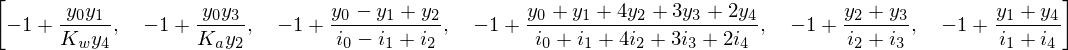

In [5]:
import sympy as sp
sp.init_printing()
ny = len(substances)
y = sp.symarray('y', ny)
i = sp.symarray('i', ny)
Kw, Ka, sigma = sp.symbols('K_w K_a sigma')
w_autop.params = Kw
NH4p_pr.params = Ka
rs = EqSystem(equilibria, substances)
#f, elim, red_cbs = rs.f(y, i, scaling=sigma, pres1st=True, presw=1000, norm=True, const_indices=(4,))
ss = sp.symarray('s', ny)
ms = sp.symarray('m', ny)
f, elim, red_cbs = rs.f(y, i, norm=True)
#tanh_subs = [(yi, m + s*sp.tanh((yi - m)/s)) for
#             yi, m, s in zip(y, ms, ss)]
#f = [_.subs(tanh_subs) for _ in f]
f

In [6]:
j = sp.Matrix(1, len(f), lambda _, q: f[q]).jacobian(y[:-1])
jarr = np.array(j.subs(zip(y,x0)).subs({sigma: 1e1, Kw: 1e-14, Ka: 10**-9.26}).subs(
            zip(i, reaction_system.as_per_substance_array(init_conc))))
#jarr = np.asarray(jarr, dtype=np.float64)
#np.log10(np.linalg.cond(jarr))

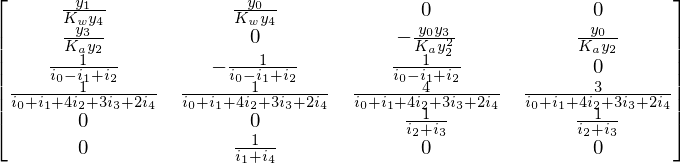

In [7]:
j

In [8]:
[s.name for s in rs.substances]

['H{+}', 'HO{-}', 'NH3 + H{+}', 'NH3', 'H2O']

In [9]:
rs.charge_balance_vector(), rs.atom_balance_vectors()

In [10]:
rs.rref()

In [11]:
np.set_printoptions(4, linewidth=120)
scaling = 1e8
for rxn in rs.rxns:
    rxn.params = rxn.params.subs({Kw: 1e-14, Ka: 10**-9.26})

In [12]:
x, res = rs.root(x0, scaling=1, logC=False, square=False)
res.success

True

In [13]:
x, res = rs.root({Hp: 1e-11, OHm: 1e-3, NH4p: 1e-3, NH3: 1.0, H2O: 55.5}, scaling=1, logC=False, square=False)
res.success

True

In [14]:
x, res = rs.root({Hp: 1.7e-11, OHm: 3e-2, NH4p: 3e-2, NH3: 0.97, H2O: 55.5}, scaling=1e8, logC=False, square=False)
res.success

True

In [15]:
x, res = rs.root({Hp: 1.7e-11, OHm: 3e-2, NH4p: 3e-2, NH3: 0.97, H2O: 55.5}, scaling=1e16, logC=True, square=False)
x

array([  1.7748e-11,   3.0000e-02,   3.0000e-02,   9.7000e-01,   5.5500e+01])

In [16]:
rs.root(x0, scaling=1e8, logC=False, square=False)

(array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01]),
   status: 1
 success: True
     qtf: array([  6.9353e-18,  -3.2796e-31,  -1.5506e-27,   2.2387e-19,   8.5491e-23])
    nfev: 59
       r: array([ -3.0996e+01,   4.7350e-14,   7.0152e-08,   3.2262e-02,  -3.2262e-02,   1.0000e+00,   1.8157e-05,  -4.8463e-14,
         1.0000e+00,  -1.0000e+00,  -1.0000e+00,  -6.9229e-09,  -9.9948e-01,   9.9948e-01,  -5.4210e-20])
     fun: array([ -2.1176e-22,  -6.9389e-18,   0.0000e+00,   0.0000e+00,   0.0000e+00])
       x: array([  1.7739e-03,   3.1270e+06,   3.1270e+06,   9.6873e+07,   5.5469e+09])
 message: 'The solution converged.'
    fjac: array([[ -1.8188e-05,  -9.9948e-01,  -3.2262e-02,   4.7289e-14,  -2.7756e-17],
       [  3.1969e-13,   4.7254e-14,   1.5565e-15,   1.0000e+00,  -6.7762e-21],
       [  3.3419e-13,   2.2347e-10,  -6.9229e-09,  -1.2082e-21,  -1.0000e+00],
       [ -5.8708e-07,  -3.2262e-02,   9.9948e-01,  -1.1322e-16,  -6.9265e-09],
       [ -1.0000e+

In [17]:
rs.root(x0, scaling=1, logC=False, square=False)

(array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01]),
   status: 1
 success: True
     qtf: array([  2.0670e-25,  -2.5521e-37,  -3.5277e-36,   6.6722e-27,   7.9827e-25])
    nfev: 67
       r: array([ -3.0996e+01,  -5.8163e-18,   1.7565e-08,   3.2262e-02,  -3.2262e-02,   1.0000e+00,   1.0017e-25,   0.0000e+00,
         1.0000e+00,  -1.0000e+00,  -1.0000e+00,  -5.6669e-10,  -9.9948e-01,   9.9948e-01,   6.4981e-13])
     fun: array([  3.5025e-28,   0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00])
       x: array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01])
 message: 'The solution converged.'
    fjac: array([[ -1.8188e-05,  -9.9948e-01,  -3.2262e-02,   0.0000e+00,   0.0000e+00],
       [  3.1969e-13,  -5.6980e-18,  -3.6993e-18,   1.0000e+00,   0.0000e+00],
       [ -3.1947e-13,   1.8292e-11,  -5.6669e-10,   1.0017e-25,  -1.0000e+00],
       [ -5.8708e-07,  -3.2262e-02,   9.9948e-01,   0.0000e+00,  -5.6698e-10],
       [ -1.0000e+

In [18]:
rs.root(x0, scaling=1.0, logC=False, reduced=True)

(array([  3.1270e-02,   3.1270e-02,   1.7739e-11,   9.6873e-01,   5.5469e+01]),
   status: 1
 success: True
     qtf: array([ -8.2825e-15,  -2.3461e-27])
    nfev: 50
       r: array([ -3.0980e+01,   3.0980e+01,  -6.4659e-13])
     fun: array([  1.5072e-19,   8.2825e-15])
       x: array([  0.9687,  55.4687])
 message: 'The solution converged.'
    fjac: array([[ -1.8197e-05,  -1.0000e+00],
       [  1.0000e+00,  -1.8197e-05]])
    njev: 7)

/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/bjorn/.local/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


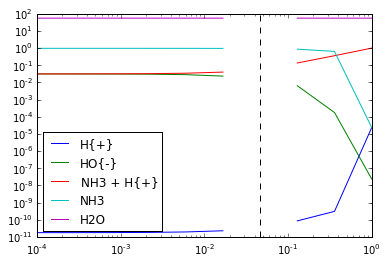

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
ny = len(rs.substances)
nc = 10
x = np.empty((nc, ny))
Hparr = np.logspace(-4, 0, nc)
success = []
for idx in range(nc):
    x00 = x0[:]
    x00[0] = Hparr[idx]
    resx, res = rs.root(x00, scaling=1e12)
    success.append(res.success)
    x[idx, :] = resx
for idx_s in range(ny):
    plt.loglog(Hparr, x[:, idx_s], label=rs.substances[idx_s].name)
plt.legend(loc='best')
for i, s in enumerate(success):
    if s is False:
        plt.axvline(Hparr[i], c='k', ls='--')

In [20]:
init_conc

{<aqchem.chemistry.Solute at 0x7f9bfa1db9d0>: 1e-07,
 <aqchem.chemistry.Solute at 0x7f9bfa1dbf90>: 1e-07,
 <aqchem.chemistry.Solute at 0x7f9bfa1de090>: 1.0,
 <aqchem.chemistry.Solute at 0x7f9bfa1de6d0>: 1e-07,
 <aqchem.chemistry.Solute at 0x7f9bfa1dea10>: 55.5}

/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The number of calls to function has reached maxfev = 500.
  warnings.warn(msg, RuntimeWarning)


True

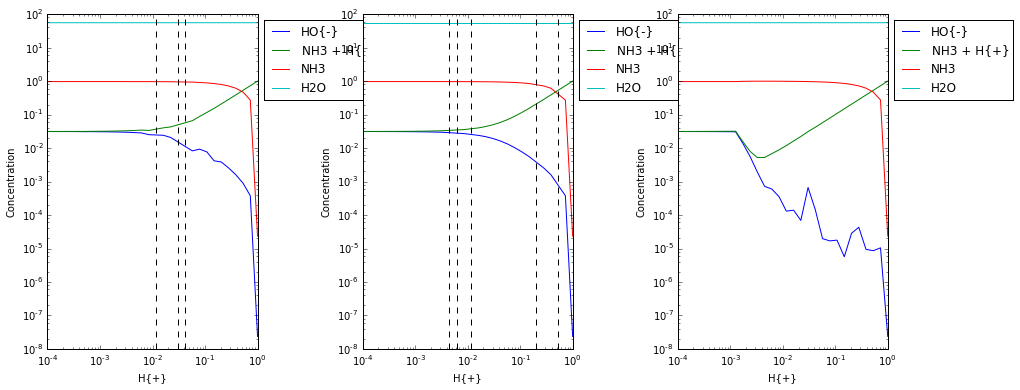

In [21]:
nc=30
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 3, 1, xscale='log', yscale='log')
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, ax=ax1)
ax2 = plt.subplot(1, 3, 2, xscale='log', yscale='log')
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, const=(H2O,), ax=ax2)
ax3 = plt.subplot(1, 3, 3, xscale='log', yscale='log')
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, method='lm', ax=ax3)
all(success)

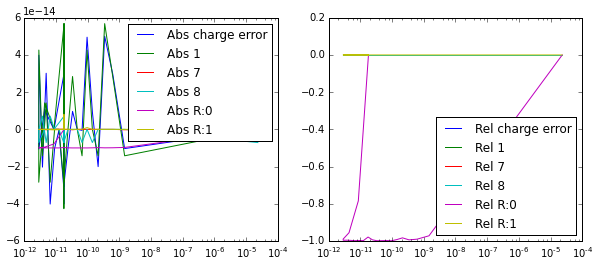

In [22]:
rs.plot_errors(Cout_14, ic, Hp)

False

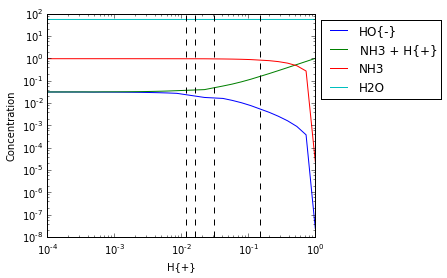

In [23]:
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, pres1st=True)
all(success)

True

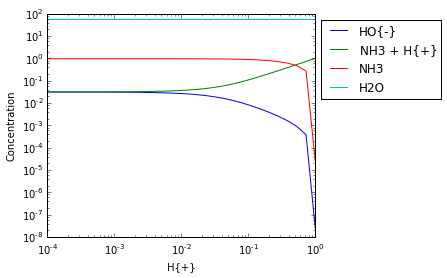

In [25]:
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, pres1st=True, norm=True, method='lm')
all(success)

In [ ]:
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, pres1st=True, norm=True, init_iter=15)
all(success)

In [ ]:
nc = 40
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e3,
                                pres1st=True, norm=True, init_iter=10, presw=10000)#, carry=True)
all(success)

In [ ]:
Cout, inits, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, pres1st=True, presw=1, norm=True, init_iter=15)
all(success)

In [ ]:
subst = tuple(rs.substances)
import random
random.shuffle(rs.substances)
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, 30), scaling=1e14)
rs.substances = list(subst)
all(success)

In [ ]:
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, norm=True)
all(success)

In [ ]:
Cout_logC, inits_out, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e3, logC=True,
                                        presw=10000)
all(success)

In [ ]:
rs.plot_errors(Cout_logC, inits_out, Hp)

In [ ]:
Cout_logC, inits_out, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), logC=True, init_guess=Cout_14, init_iter=0)
all(success)

In [ ]:
Cout_14, ic14, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, carry=True)
all(success)

In [ ]:
_1, _2, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e-4, tol=1e-12, init_iter=100)
all(success)

In [ ]:
_1, _2, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e-8)
all(success)

In [ ]:
_1, _2, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e-8, carry=True)
all(success)

In [ ]:
Cout, inits_out, success = rs.plot(Cout_14, Hp, np.logspace(-4, 0, nc), scaling=1, init_iter=0, method='lm')
all(success), Cout.shape

In [ ]:
Cout, inits_out, success = rs.plot(Cout_14, Hp, np.logspace(-4, 0, nc), scaling=1, logC=True, init_iter=0, method='lm')
all(success)

In [ ]:
rs.plot_errors(Cout, inits_out, Hp)

In [ ]:
Cout, inits_out, success = reqsys.plot(init_conc, Hp, np.logspace(-7, 0, 20), scaling=1, carry=True)

In [ ]:
x0

In [ ]:
from aqchem.equilibria import solve_equilibrium
print(x0)
for w in range(1,5):
    for eq in rs.rxns:
        new_x0 = solve_equilibrium(x0, eq.net_stoich(rs.substances), eq.params)
        x0 = (w*x0 + new_x0)/(w+1)
        print(x0)